### Multimodal RAG With Document Retrieval and Vision Language Model

In this tutorial, we combine ColPali retriever for document retrieval with Qwen2-VL Vision Language Model (VLM).

In [1]:
# Install dependencies
!pip install -U -q byaldi pdf2image qwen-vl-utils transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.0/821.0 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!sudo apt-get install -y poppler-utils # poppler utils for PDF manipulation

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.10 [186 kB]
Fetched 186 kB in 1s (274 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 126435

Load PDF Dataset

In [3]:
import requests
import os

pdfs = {
    "MALM": "https://www.ikea.com/us/en/assembly_instructions/malm-4-drawer-chest-white__AA-2398381-2-100.pdf",
    "BILLY": "https://www.ikea.com/us/en/assembly_instructions/billy-bookcase-white__AA-1844854-6-2.pdf",
    "BOAXEL": "https://www.ikea.com/us/en/assembly_instructions/boaxel-wall-upright-white__AA-2341341-2-100.pdf",
    "ADILS": "https://www.ikea.com/us/en/assembly_instructions/adils-leg-white__AA-844478-6-2.pdf",
    "MICKE": "https://www.ikea.com/us/en/assembly_instructions/micke-desk-white__AA-476626-10-100.pdf",
}

output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

for name, url in pdfs.items():
    response = requests.get(url)
    pdf_path = os.path.join(output_dir, f"{name}.pdf")

    with open(pdf_path, "wb") as f:
        f.write(response.content)

    print(f"Downloaded {name} to {pdf_path}")

print("Downloaded files:", os.listdir(output_dir))

Downloaded MALM to data/MALM.pdf
Downloaded BILLY to data/BILLY.pdf
Downloaded BOAXEL to data/BOAXEL.pdf
Downloaded ADILS to data/ADILS.pdf
Downloaded MICKE to data/MICKE.pdf
Downloaded files: ['BOAXEL.pdf', 'MALM.pdf', 'ADILS.pdf', 'BILLY.pdf', 'MICKE.pdf']


In [4]:
# Convert PDFs to Images
import os
from pdf2image import convert_from_path

def convert_pdfs_to_images(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        all_images[doc_id] = images

    return all_images


all_images = convert_pdfs_to_images("/content/data/")

In [ ]:
# View sample image
all_images[0][0]

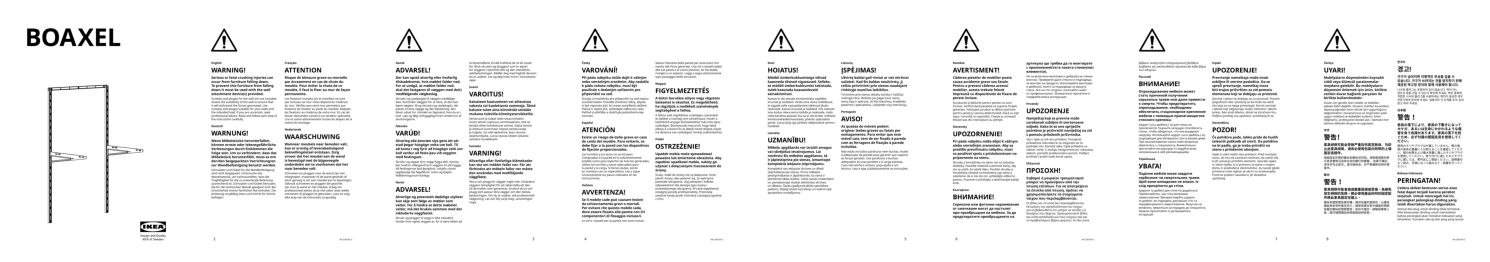

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 8, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = all_images[0][i]
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

Initialize the ColPali Multimodal Document Retrieval Model

the model is used to extract relevant information from the raw images and to provide with appropriate document based on user queries [Byaldi](https://github.com/AnswerDotAI/byaldi)

In [10]:
from byaldi import RAGMultiModalModel

docs_retrieval_model = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [13]:
docs_retrieval_model.index(
    input_path="data/", index_name="image_index", store_collection_with_index=False, overwrite=True
)

Indexing file: data/BOAXEL.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Index exported to .byaldi/image_index
Indexing file: data/MALM.pdf
Added page 1 of document 1 to index.
Added page 2 of document 1 to index.
Added page 3 of document 1 to index.
Added page 4 of document 1 to index.
Add

{0: 'data/BOAXEL.pdf',
 1: 'data/MALM.pdf',
 2: 'data/ADILS.pdf',
 3: 'data/BILLY.pdf',
 4: 'data/MICKE.pdf'}

Retrieve Documents with the Document Retrieval Model

In [14]:
text_query = "How do I assemble the Malm?"

results = docs_retrieval_model.search(text_query, k=3)
results

[{'doc_id': 1, 'page_num': 1, 'score': 14.125, 'metadata': {}, 'base64': None},
 {'doc_id': 4, 'page_num': 15, 'score': 10.625, 'metadata': {}, 'base64': None},
 {'doc_id': 3, 'page_num': 10, 'score': 10.375, 'metadata': {}, 'base64': None}]

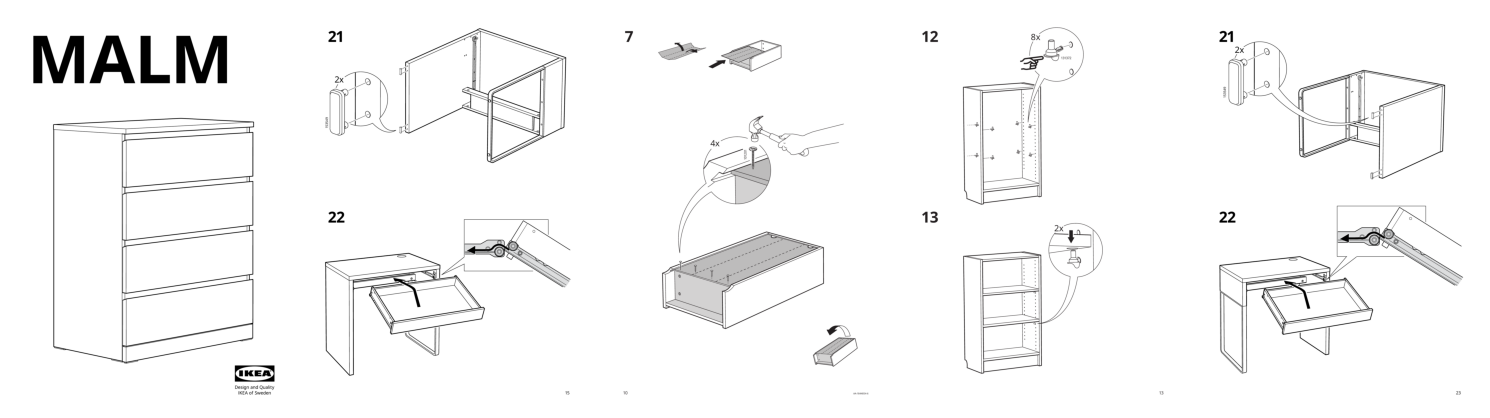

In [23]:
import matplotlib.pyplot as plt

text_query = "How do I assemble the Malm?"

results = docs_retrieval_model.search(text_query, k=5)

def get_grouped_images(results, all_images):
    grouped_images = []
    for result in results:
        doc_id = result["doc_id"]
        page_num = result["page_num"]
        grouped_images.append(
            all_images[doc_id][page_num - 1]
        )  # page_num are 1-indexed, while doc_ids are 0-indexed. Source https://github.com/AnswerDotAI/byaldi?tab=readme-ov-file#searching
    return grouped_images


grouped_images = get_grouped_images(results, all_images)

fig, axes = plt.subplots(1, 5, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = grouped_images[i]
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

Next we initialize the Vision Language Model ([Qwen2L](https://huggingface.co/docs/transformers/main/en/model_doc/qwen2_vl)) for Question and Answering

In [24]:
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info
import torch

vl_model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
)
vl_model.cuda().eval()

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

Qwen2VLForConditionalGeneration(
  (model): Qwen2VLModel(
    (visual): Qwen2VisionTransformerPretrainedModel(
      (patch_embed): PatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2VLVisionBlock(
          (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (attn): VisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): VisionMlp(
            (fc1): Linear(in_features=1280, out_features=5120, bias=True)
            (act): QuickGELUActivation()
            (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          )
        )
      )
      (merger): PatchMerger(
        (ln_q): LayerN

In [31]:
# Optimize image resolution for performance
min_pixels = 224 * 224
max_pixels = 1024 * 1024
vl_model_processor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels
)

# Create chat template
chat_template = [
    {
        "role": "user",
        "content": []
    }
]

for i in range(5):
    chat_template[0]["content"].append({'text': 'image',
                                        'image': grouped_images[i]})
chat_template[0]['content'].append({'type': 'text', 'text': text_query})

In [32]:
text = vl_model_processor.apply_chat_template(chat_template, tokenize=False, add_generation_prompt=True)

image_inputs, _ = process_vision_info(chat_template)
inputs = vl_model_processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Generate the answer
generated_ids = vl_model.generate(**inputs, max_new_tokens=500)

# Postprocess generated answer
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
output_text = vl_model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [33]:
print(output_text[0])

To assemble the Malm, follow these steps:

1. **Prepare the Drawer**:
   - Place the drawer on the floor.
   - Attach the drawer front to the drawer sides using the screws provided.

2. **Attach the Drawer to the Frame**:
   - Place the drawer on the frame.
   - Secure the drawer to the frame using the screws provided.

3. **Install the Drawer Slides**:
   - Attach the drawer slides to the frame.
   - Ensure the slides are securely fastened to the frame.

4. **Install the Drawer Front**:
   - Place the drawer front on the drawer.
   - Secure the drawer front to the drawer using the screws provided.

5. **Install the Drawer Back**:
   - Place the drawer back on the drawer.
   - Secure the drawer back to the drawer using the screws provided.

6. **Install the Drawer Knob**:
   - Attach the drawer knob to the drawer front.
   - Ensure the knob is securely fastened to the drawer front.

7. **Install the Drawer Handle**:
   - Attach the drawer handle to the drawer front.
   - Ensure the han

In [ ]:
# Combine Code
def answer_with_multimodal_rag(
    vl_model, docs_retrieval_model, vl_model_processor, grouped_images, text_query, top_k, max_new_tokens
):
    results = docs_retrieval_model.search(text_query, k=top_k)
    grouped_images = get_grouped_images(results, all_images)

    chat_template = [
        {
            "role": "user",
            "content": [{"type": "image", "image": image} for image in grouped_images]
            + [{"type": "text", "text": text_query}],
        }
    ]

    # Prepare the inputs
    text = vl_model_processor.apply_chat_template(chat_template, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(chat_template)
    inputs = vl_model_processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Generate text from the vl_model
    generated_ids = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

    # Decode the generated text
    output_text = vl_model_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text

output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    grouped_images=grouped_images,
    text_query="How do I assemble the Micke desk?",
    top_k=3,
    max_new_tokens=500,
)
print(output_text[0])

https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_vlms